<a href="https://colab.research.google.com/github/KeremAydin98/gan-mnist-image-generation/blob/main/DCGAN_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
(X_train, y_train),(_,_) = cifar10.load_data()

In [ ]:
classes={
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck"}

In [ ]:
X_train = X_train[y_train.flatten()==7]

In [ ]:
X_train.shape

(5000, 32, 32, 3)

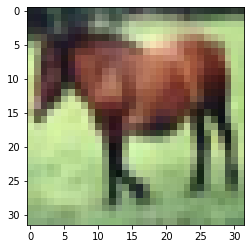

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train = X_train.astype('float32')
X_train /= 127.5
X_train -= 1

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, LeakyReLU, Reshape, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
latent_dim = 32
height = 32
width = 32
channels = 3


generator = Sequential()
generator.add(Dense(128 * 16* 16, input_shape = [latent_dim]))
generator.add(LeakyReLU())
generator.add(Reshape([16,16,128]))

generator.add(Conv2D(256, 5, padding = 'same'))
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(256, 4, strides = 2, padding = 'same'))
generator.add(LeakyReLU())

generator.add(Conv2D(256, 5, padding='same'))
generator.add(LeakyReLU())
generator.add(Conv2D(256, 5, padding='same'))
generator.add(LeakyReLU())

generator.add(Conv2D(channels, 7, padding='same', activation = 'tanh'))

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      1048832   
 nspose)                                                         
                                                        

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(128, 3, input_shape = [width, height, channels]))
discriminator.add(LeakyReLU())

discriminator.add(Conv2D(128, 4, strides = 2))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, 4, strides = 2))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())
discriminator.add(Conv2D(128, 4, strides = 2))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU())


discriminator.add(Flatten())
discriminator.add(Dropout(0.5))

discriminator.add(Dense(1, activation = 'sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                      

In [ ]:
import tensorflow
discriminator_optimizer = tensorflow.keras.optimizers.RMSprop(
learning_rate=0.0002,
clipvalue=1.0,
decay=1e-8)

discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy')

discriminator.trainable = False

GAN = Sequential([generator, discriminator])

gan_optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)
GAN.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy')

In [ ]:
import numpy as np

epochs = 40000
batch_size = 20
sample_interval = 5000

generator, discriminator = GAN.layers


def train(epochs, batch_size, sample_interval):

  start = 0

  for step in range(epochs):

    for i in range(5):

      #Samples random points in the latent space
      random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

      #Decodes them to fake images
      generated_images = generator.predict(random_latent_vectors)

      #Combines them with real images
      stop = start + batch_size
      real_images = X_train[start:stop]
      combined_images = np.concatenate([generated_images, real_images])

      #Assembles labels, discriminating real images from fake images
      labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

      #Adds random noise to labels
      labels += 0.05 * np.random.random(labels.shape)

      #Trains the discriminator
      d_loss = discriminator.train_on_batch(combined_images, labels)

    #Samples random points in the latent space(create new random points for the generator training)
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))

    #Assembles labels that say these are all real images(it's a lie!)
    misleading_targets = np.zeros((batch_size, 1))

    #Train the generator
    g_loss = GAN.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > (len(X_train) - batch_size):
      start = 0

    if (step+1) % 1000 == 0:
      GAN.save_weights('cifar_gan.h5')

      print('Step: ', f"{step + 1}/{epochs}")
      print('Discriminator loss: ', d_loss)
      print('Generator loss: ', g_loss)
      print("\n")
    
    if (step+1) % sample_interval == 0:

      sample_images(generator,step+1)


In [ ]:
from tensorflow.keras.preprocessing import image

def sample_images(generator,step):

  nb_images = 3
  noise = np.random.normal(size = (nb_images, latent_dim))
  fake_images = generator.predict(noise)

  for fake, i in zip(fake_images,range(nb_images)):
    img = image.array_to_img(fake * 255., scale=False)
    plt.imshow(img)
    plt.show()
    plt.savefig(f"{step}{i}.png")


Step:  1000/40000
Discriminator loss:  0.14609394967556
Generator loss:  20.7099609375


Step:  2000/40000
Discriminator loss:  0.13944712281227112
Generator loss:  5.282927513122559


Step:  3000/40000
Discriminator loss:  0.08117641508579254
Generator loss:  2.503422498703003


Step:  4000/40000
Discriminator loss:  -0.01634160242974758
Generator loss:  4.924506187438965


Step:  5000/40000
Discriminator loss:  -0.005959755275398493
Generator loss:  3.574176788330078




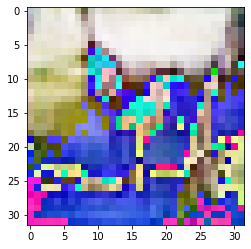

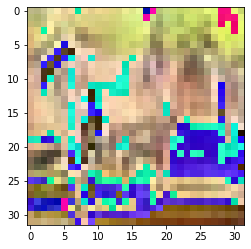

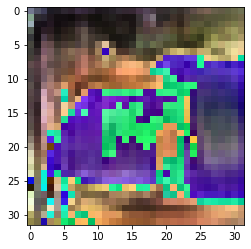

Step:  6000/40000
Discriminator loss:  -0.07825035601854324
Generator loss:  0.7858713865280151


Step:  7000/40000
Discriminator loss:  -0.00018696785264182836
Generator loss:  4.163687229156494


Step:  8000/40000
Discriminator loss:  0.04460243508219719
Generator loss:  2.6779799461364746


Step:  9000/40000
Discriminator loss:  0.1088346391916275
Generator loss:  2.106102705001831


Step:  10000/40000
Discriminator loss:  0.11303634941577911
Generator loss:  7.797649383544922




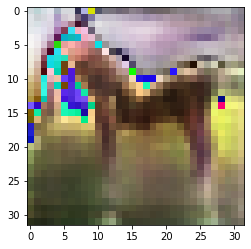

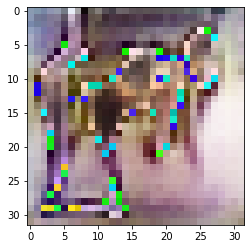

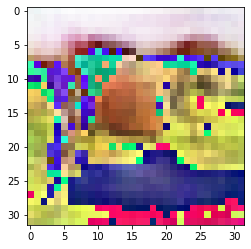

Step:  11000/40000
Discriminator loss:  0.04405054822564125
Generator loss:  2.8125574588775635


Step:  12000/40000
Discriminator loss:  -0.022709708660840988
Generator loss:  8.571006774902344


Step:  13000/40000
Discriminator loss:  -0.07833239436149597
Generator loss:  3.092042922973633


Step:  14000/40000
Discriminator loss:  -0.13951626420021057
Generator loss:  0.8059861063957214


Step:  15000/40000
Discriminator loss:  -0.2573516368865967
Generator loss:  4.9895124435424805




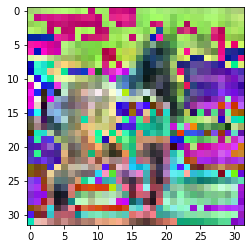

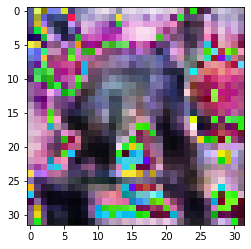

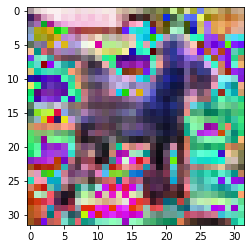

Step:  16000/40000
Discriminator loss:  0.06638986617326736
Generator loss:  4.858341693878174


Step:  17000/40000
Discriminator loss:  -0.42085251212120056
Generator loss:  0.043772656470537186


Step:  18000/40000
Discriminator loss:  0.09601221978664398
Generator loss:  12.846020698547363


Step:  19000/40000
Discriminator loss:  0.017945419996976852
Generator loss:  6.502621650695801


Step:  20000/40000
Discriminator loss:  0.13504251837730408
Generator loss:  3.835573673248291




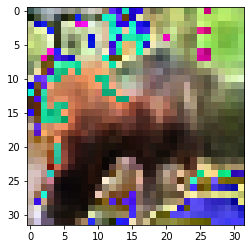

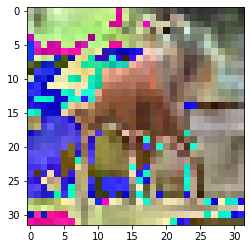

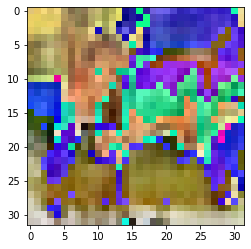

Step:  21000/40000
Discriminator loss:  -0.16812166571617126
Generator loss:  8.428203582763672


Step:  22000/40000
Discriminator loss:  0.02763894759118557
Generator loss:  1.118528962135315


Step:  23000/40000
Discriminator loss:  -0.03847035393118858
Generator loss:  12.242047309875488


Step:  24000/40000
Discriminator loss:  0.31302735209465027
Generator loss:  1.7553622722625732


Step:  25000/40000
Discriminator loss:  0.7300428748130798
Generator loss:  5.698105812072754




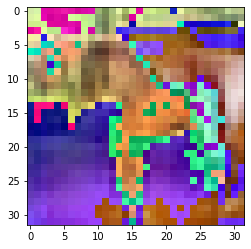

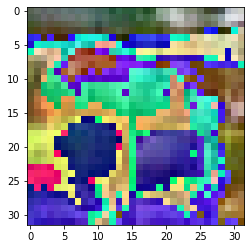

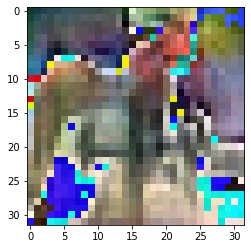

Step:  26000/40000
Discriminator loss:  -0.17161835730075836
Generator loss:  6.243579864501953


Step:  27000/40000
Discriminator loss:  -0.1587570160627365
Generator loss:  0.8917160034179688


Step:  28000/40000
Discriminator loss:  -0.3341463804244995
Generator loss:  5.464723110198975


Step:  29000/40000
Discriminator loss:  0.021143030375242233
Generator loss:  7.279345512390137


Step:  30000/40000
Discriminator loss:  -0.06671280413866043
Generator loss:  1.003483533859253




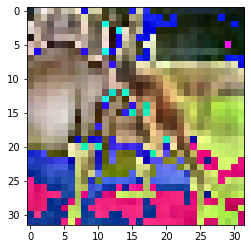

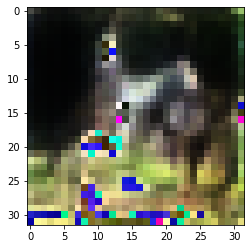

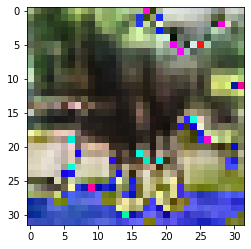

In [ ]:
train(epochs, batch_size, sample_interval)